# Банки — Анализ оттока клиентов

### Материалы
* [Презентация](https://disk.yandex.ru/i/HAxsfHY9DVNULQ)

**Цель исследования:** Проанализировать клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка

**Ход исследования:** Данные берем из файла bank_scrooge.csv

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Этапы исследования:**

Шаг 1. Открыть файл с данными и изучить общую информацию;
 - Открыть файл с данными. Визуально посмотреть на содержимое таблицы;
 - Посмотреть общую информацию по таблице;
 - Проверить пропуски, а так же явные и не явные дубликаты.
 
Шаг 2. Подготовить данные;
 - Привести названия столбцов к нижнему регистру, для более удобного использования;
 - Провести анализ природы пропусков и если потребуется их обработку.

Шаг 3. Провести исследовательский анализ данных;
 - Посмотреть на рапределение данных с построением гистограмм для наглядности. С целью поиска критериев для последующей сегментации клиентов;
 - Оценить взаимосвязь между критериями и возможным оттоком клиентов на основе проведения корреляционного анализа.

Шаг 4. Проверить гипотезы;
 - Проверить гипотезу по различию дохода клиентов что ушли и теми что остались;
 - Остальные гипотезы будут сформулированы в процессе анализа.

Шаг 5. Промежуточные итоги;
 - Подведение итогов после проведения исследовательского анализа признаков, корреляционного анализа, а так же проверки основных гипотез;
 - Основные выводы.

Шаг 6. Сегментация клиентов;
 - Проведение сегментации клиентов на основании признаков что были определены при анализе даных;

1) Инструмент.

За инструмент сегментации клиентов возьмем метод машинного обучения К-Means. Так как метод относительно прост в реализации и может обрабатывать большие объемы данных, а так же умеет работать как с числовыми, так и с категориальными переменными. Данный метод отлично подойдет для нахождения кластеров по оттоку клиентов.

2) Метрика

Для метрики будем использовать количество пользователей в каждом из кластеров. Должно быть не менее 500. И средний отток по кластеру должен быть выше среднего по банку в целом.

3) Способ определения кластеров.

Для определения количества кластеров возьмем метод агломеративной кластеризации с построением дендрограммы для визуального отображения кластеров. Агломеративная кластеризация подходит для анализа оттока клиентов из-за своей способности обрабатывать данные без предварительного знания о числе кластеров. В контексте оттока клиентов, может помочь идентифицировать группы клиентов со схожими характеристиками, которые могут вызвать отток.

4) Критерий хорошей кластеризации

За критерий хорошего кластера будем использовать значение оттока по кластеру. Если значение выше среднебанковского будем считать данный кластер "хорошим".

 - Проведение приоретизации полученных сегментов.

Шаг 7. Написать общий вывод.
 - Для каждого из сегментов предложить рекомендации по снижению оттока.

**Описание данных:**

- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — количество баллов собственности,
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — активный клиент,
- EST_SALARY — оценочный доход клиента,
- сhurn — признак оттока.

In [3]:
pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.5 MB/s eta 0:00:00


In [4]:
pip install --upgrade phik

In [6]:
import pandas as pd
import phik
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

## Шаг 1. Открыть файл с данными и изучить общую информацию

### Открыть файл с данными. Визуально посмотреть на содержимое таблицы

In [10]:
# Загружаем файл
pth1 = '/content/bank_scrooge.csv'

if os.path.exists(pth1):
    banks = pd.read_csv(pth1)
else:
    print('Что-то не так с файлом. Проверь файл с данными.')

In [12]:
# Выведем данные таблицы
banks.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


Видим что названия толбцов имеют разный регистр. Для удобства стоит привести названия столбцов к нижнем урегистру.

### Посмотреть общую информацию по таблице

In [13]:
# Посмотрим на общую информацию, используя метод info()
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Из общей информации видим, что в таблице всего 10000 строк. Есть пропуски в двух столбцах: age и balance.

### Проверить пропуски, а так же явные и не явные дубликаты.

In [14]:
# Проверим процент пропусков по столбцам
na = banks.isna().sum().sort_values()
na_perc = round(banks.isna().mean()*100,2).sort_values()
display(pd.DataFrame({'Количество пропусков':na,'% пропусков':na_perc}).style.format('{:.2f}').background_gradient('coolwarm'))

,Количество пропусков,% пропусков
USERID,0.00,0.00
score,0.00,0.00
city,0.00,0.00
gender,0.00,0.00
equity,0.00,0.00
products,0.00,0.00
credit_card,0.00,0.00
last_activity,0.00,0.00
EST_SALARY,0.00,0.00
churn,0.00,0.00


In [15]:
# Выведем отсортированные значения столбца balance
banks['balance'].sort_values().tolist()

[0.0,
 0.0,
 6.0,
 7.0,
 20.0,
 21.0,
 22.0,
 26.0,
 26.0,
 33.0,
 38.0,
 38.0,
 39.0,
 39.0,
 40.0,
 42.0,
 43.0,
 45.0,
 48.0,
 56.0,
 60.0,
 63.0,
 73.0,
 86.0,
 146.0,
 174.0,
 176.16,
 178.0,
 211.53,
 239.0,
 276.0,
 780.42,
 798.27,
 1876.0,
 3346.76,
 3396.37,
 4778.12,
 5561.11,
 5750.92,
 5899.36,
 5906.64,
 6739.19,
 7703.05,
 7713.05,
 8126.88,
 8155.48,
 8373.69,
 8881.01,
 9008.69,
 9040.68,
 9253.18,
 9459.77,
 9753.01,
 9878.17,
 10105.01,
 10582.89,
 10589.99,
 11629.51,
 11733.68,
 11978.32,
 12946.78,
 13074.06,
 13214.15,
 13675.49,
 14674.32,
 15017.21,
 15704.08,
 15723.1,
 16937.06,
 17202.68,
 18965.1,
 19817.5,
 20374.1,
 21136.75,
 21698.0,
 21996.15,
 22912.37,
 23250.59,
 23671.3,
 24074.1,
 24268.13,
 24405.4,
 25253.54,
 25293.25,
 25354.23,
 25445.45,
 25514.59,
 25642.42,
 26312.31,
 26361.03,
 26371.78,
 27030.33,
 27031.76,
 27592.34,
 28315.55,
 28374.75,
 28751.28,
 28914.07,
 29178.41,
 29565.79,
 29863.64,
 29876.43,
 30610.61,
 31111.2,
 32390.65,

Видим, что больше всего пропуско, почти 23% в столбце balance. При этом в значениях столбца есть как нулевые так и не нулевые значения. Чтобы понять как поступить с данными пропусками определим к какому типу они относятся. На основании чего сможем решить что с ними делать.

In [16]:
# Теперь проверим таблицу на явные дубликаты
print("Количество явных дубликатов в таблице:", banks.duplicated().sum())

Количество явных дубликатов в таблице: 0


In [17]:
# Проверим не явные дубликаты по пользователю, городу, возрасту и гендеру
banks[banks.duplicated(subset = ['USERID', 'city', 'age', 'gender'], keep = False)]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn


In [18]:
# А так же по пользователю и городу
banks[banks.duplicated(subset = ['USERID', 'city'], keep = False)]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn


Видим что явных дубликатов в таблице нет. При этом и неявных по пользователю и городу, так же пользователю, городу, возрасту и гендеру нет. Поэтому проверим отдельно юзер айди.

In [19]:
# Посмотрим отдельно на дубликаты по пользователю
banks[banks.duplicated(subset = ['USERID'], keep = False)]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


In [20]:
# Чтобы рассмотреть подробнее выведем например две дублирующие строки
banks.loc[banks["USERID"] == 218868]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0


При сравнении строк есть различия в городе, сумме зарплаты, баланса и скоре. Но сходятся гендер, количество продуктов, наличие кредитки. Давайте рассмотрим еще одну пару.

In [21]:
banks.loc[banks["USERID"] == 164676]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
7271,164676,790.0,Рыбинск,Ж,77.0,1,111202.01,1,1,0,32835.45,0


А вот тут уже нет совпадений кроме наличия кредитной карты и юзер айди. То есть можно предположить что совпадение айди происходит, так как у нас есть данные из трех филиалов банка. При этом это разные пользователи. Явных как и не явных дубликатов мы не нашли. Имееются только совпадения по юзер айди.

**Вывод:**
    
В таблице всего 10000 строк. При это имеются пропуски в двух столбцах: возраст и баланс. Пропусков в столбце возраст меньше процента, поэтому их оставим без изменения. Влияния на результаты исследования они не окажут. А вот в столбце баланс целых 23% пропусков, природу которых мы выясним на следущем этапе.

Что касается дубликатов. Явных дубликатов не обнаружено. При этом есть дубли в юзер айди. После проверки мы пришли к выводу что это разные пользователи, есть совпадение только в самом айди пользователя.

## Шаг 2. Подготовить данные

### Провести анализ природы пропусков и если потребуется их обработку.

In [22]:
# Создадим новый признак, принимающий 1, если в наблюдении пропущено значение, и 0, если значение не пропущено
banks['mis_bal'] = banks['balance'].isnull().astype(int)

In [23]:
# Передадим в interval_cols непрерывные признаки
interval_cols = ['score', 'age', 'balance', 'EST_SALARY']

In [24]:
# После чего посмотрим на корреляцию используя библеотеку phik.
banks.phik_matrix(interval_cols=interval_cols)

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable USERID is large: 9927. Are you sure this is not an interval variable? Analysis for pairs of variables including USERID can be slow.
  warnings.warn(


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,mis_bal
USERID,1.000000,0.422667,0.000000,0.458907,0.788355,0.808662,1.000000,0.000000,0.326078,0.639871,0.838116,0.000000,0.552525
score,0.422667,1.000000,0.090984,0.071278,0.032750,0.527970,0.170897,0.309150,0.208683,0.052911,0.395681,0.229572,0.755046
city,0.000000,0.090984,1.000000,0.012720,0.091769,0.063431,0.039968,0.222573,0.074831,0.030531,0.171390,0.016811,0.040277
gender,0.458907,0.071278,0.012720,1.000000,0.286450,0.064554,0.045424,0.122547,0.196238,0.014156,0.144801,0.218799,0.097850
age,0.788355,0.032750,0.091769,0.286450,1.000000,0.046514,0.019169,0.133230,0.157632,0.090068,0.359738,0.191653,0.047756
equity,0.808662,0.527970,0.063431,0.064554,0.046514,1.000000,0.000000,0.442391,0.221940,0.051091,0.286489,0.352726,0.975823
balance,1.000000,0.170897,0.039968,0.045424,0.019169,0.000000,1.000000,0.000000,0.000000,0.000000,0.374374,0.024701,NaN
products,0.000000,0.309150,0.222573,0.122547,0.133230,0.442391,0.000000,1.000000,0.459214,0.191403,0.157906,0.441363,0.793178
credit_card,0.326078,0.208683,0.074831,0.196238,0.157632,0.221940,0.000000,0.459214,1.000000,0.049761,0.038195,0.202997,0.245296
last_activity,0.639871,0.052911,0.030531,0.014156,0.090068,0.051091,0.000000,0.191403,0.049761,1.000000,0.046097,0.261174,0.041281


По таблице видим что есть достаточно сильная зависимость между пропусками в балансе и количеством баллов собственности. А так же можно говорить о зависимости с количеством продуктов и баллами кредитного скорринга. То есть мы можем говорить что пропуски зависят от данных и их нельзя отбрасывать.

Что касается столбца с возрастом набольшаяя зависимость наблюдается со следующими столбцами: Гендер и средний доход пользователя.

In [25]:
# Так же посмотрим на меру центральной тенденции.
# Напишем функцию для подсчета медианы
def median(series):
    return series.median()

# Затем соберем сводную таблицу
banks.groupby('mis_bal').agg({
    'EST_SALARY': ['mean'],
    'age': ['mean'],
    'products': median,
    'equity': median,
    'city': pd.Series.mode,
    'gender': pd.Series.mode
}).reset_index()

,mis_bal,EST_SALARY,age,products,equity,city,gender
,,mean,mean,median,median,mode,mode
0,0,124501.872366,42.924366,2.0,4.0,Ярославль,Ж
1,1,226310.208654,42.093023,1.0,0.0,Ярославль,М


В результате видим что пропуски значений баланса больше связаны с теми пользователями у кого всего один продукт, количество баллов собственности равно нулю. Город выделяется Ярославль и в большей степени это мужчины со средним оценочным доходом 226 тыс. То есть пропуски имеются у пользователей кто не очень активно пользуется продуктами банка и о которых у банка недостаточно сведений.

То есть можно говорить о зависимости пропусков от других столбцов. Как результат пропусти не случайны и убирать их из выборки не стоит.

На основе проведенного исследования можно заключить что данные относятся к типу MNAR (Missing Not At Random / Отсутствует не случайно) и отсутствуют не случайно. Поэтому и убирать их или заменять значениями не будем чтобы не изменить итоговый результат исследования.

### Привести названия столбцов к нижнему регистру, для более удобного использования

In [26]:
# Выведем названия столбцов до преобразования
banks.columns

Index(['USERID', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'EST_SALARY', 'churn',
       'mis_bal'],
      dtype='object')

In [27]:
# Проведем преобразование с помощью метода str.lower()
banks.columns = banks.columns.str.lower()
banks.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn',
       'mis_bal'],
      dtype='object')

Как видим преобразование прошло успешно, можно двигаться дальше.

**Вывод:**
    
Мы выяснили что между пропусками в столбце баланса и другими столбцами имеется взаимосвязь. То есть пропуски имеются у пользователей кто не очень активно пользуется продуктами банка и о которых у банка недостаточно сведений. При этом больше пропусков у мужчин со средним оценочным доходом 226 тыс. Поэтому данные пропуски убирать не будем.

Так же провели преобразование названия столбцов к нижнему регистру.

## Шаг 3. Провести исследовательский анализ данных

### Посмотреть на рапределение данных

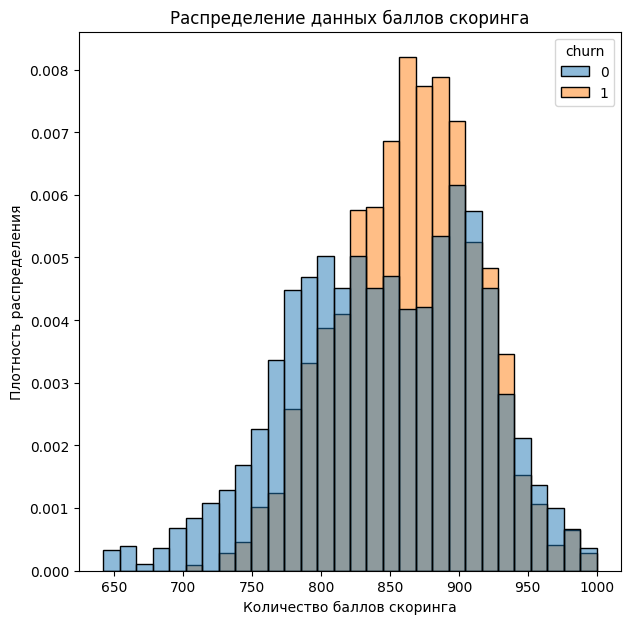

In [28]:
# Посмотрим на распределение данных баллов скоринга
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=banks, x="score", hue="churn", stat="density", common_norm=False, bins = 30)

plt.xlabel("Количество баллов скоринга", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение данных баллов скоринга")
plt.show()

Видим что диапазон скора с оттоком немного уже чем без него. При этом у пользователей склонных к оттоку заметен пик в диапазоне от 820 до 900 баллов скора.

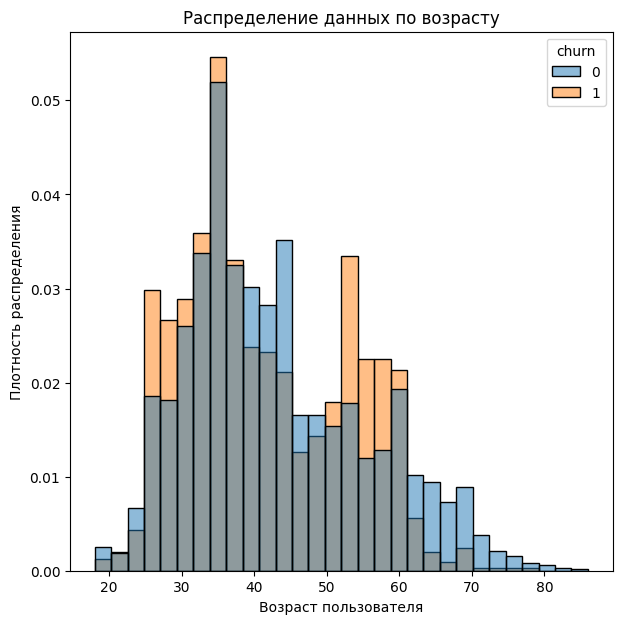

In [29]:
# Посмотрим на распределение данных по возрасту
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=banks, x="age", hue="churn", stat="density", common_norm=False, bins = 30)

plt.xlabel("Возраст пользователя", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение данных по возрасту")
plt.show()

Выделяются только группы пользователей в диапазоне от 25 до 30 и от 50 до 60 лет.

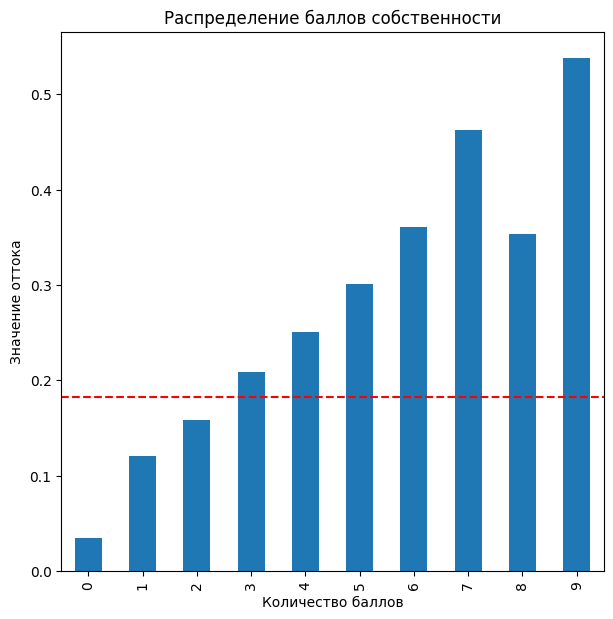

In [30]:
# Посмотрим на распределение баллов собственности
# При это выведем на графике дополнительно среднее значение по оттоку
fig, ax = plt.subplots(figsize=(7, 7))

banks.groupby(['equity'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = banks['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Количество баллов", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение баллов собственности")
plt.show()

По графику видно, что отток пользователей начинается а диапазоне от 3 до 9 баллов собственности.

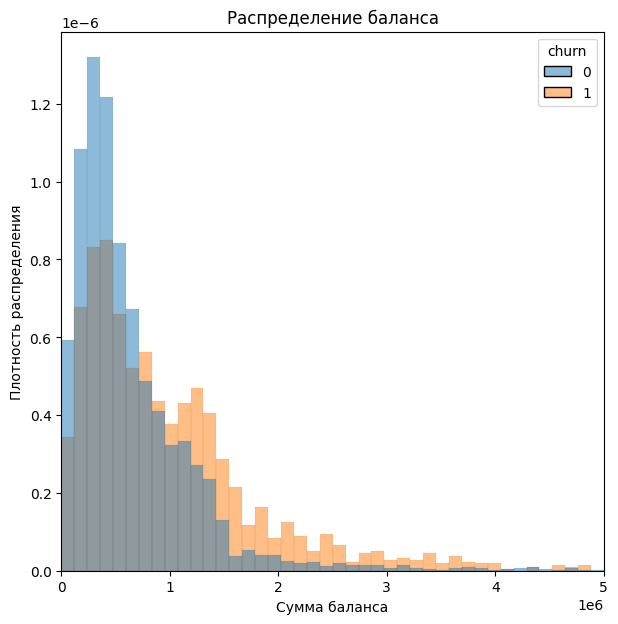

In [31]:
# Посмотрим на распределение баланса
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=banks, x="balance", hue="churn", stat="density", common_norm=False, bins = 1000)

axs.set_xlim([0, 5000000])
plt.xlabel("Сумма баланса", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение баланса")
plt.show()

Видим что более склонны к оттоку те у кого выше баланс.

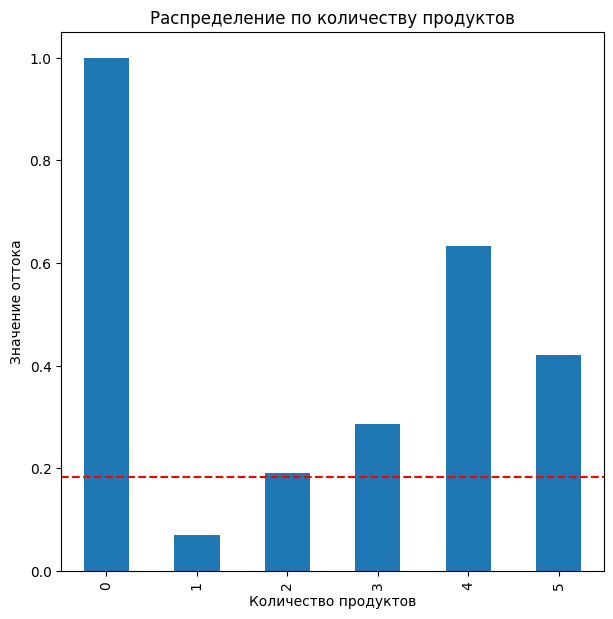

In [32]:
# Посмотрим на распределение количества продуктов
# При это выведем на графике дополнительно среднее значение по оттоку
fig, ax = plt.subplots(figsize=(7, 7))

banks.groupby(['products'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = banks['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Количество продуктов", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по количеству продуктов")
plt.show()

In [33]:
# Посмотрим на распределение пользователей по наличию продуктов.
banks.groupby(['products'])['churn'].count()

products
0       1
1    3341
2    5126
3    1039
4     474
5      19
Name: churn, dtype: int64

По наличию продутов банка более склонны к оттоку пользователи у кого более 2 продуктов. Так же стоит обратить внимание на наличие пользователя с нулевым количеством продуктов, что выглядит очень странно. При это такой пользователь всего один.

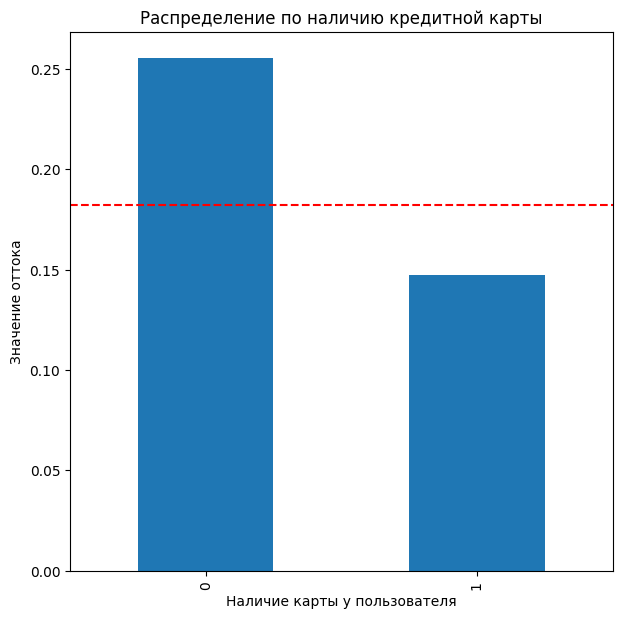

In [34]:
# Посмотрим на распределение по наличию кредитной карты
# При это выведем на графике дополнительно среднее значение по оттоку
fig, ax = plt.subplots(figsize=(7, 7))

banks.groupby(['credit_card'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = banks['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Наличие карты у пользователя", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по наличию кредитной карты")
plt.show()

Более склонны к оттоку пользователи без крединой карты. Так как значение оттока выше среднего по банку.

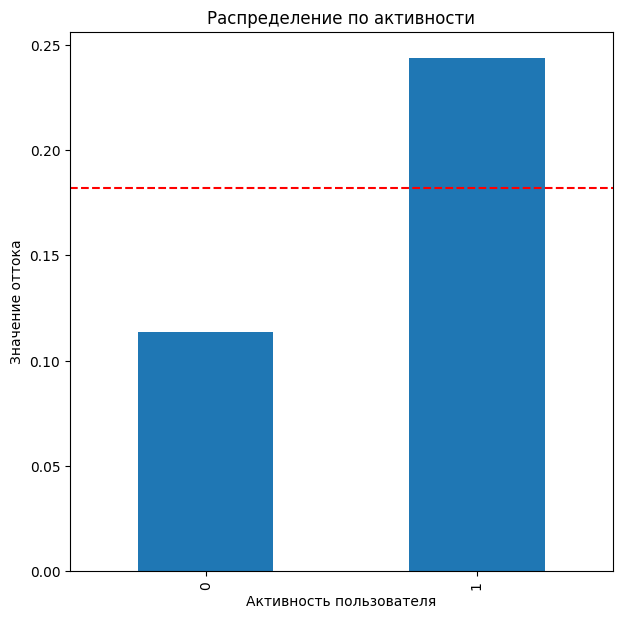

In [35]:
# Посмотрим на распределение по активности
# При это выведем на графике дополнительно среднее значение по оттоку
fig, ax = plt.subplots(figsize=(7, 7))

banks.groupby(['last_activity'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = banks['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Активность пользователя", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по активности")
plt.show()

Более склонны к оттоку активные пользователи.

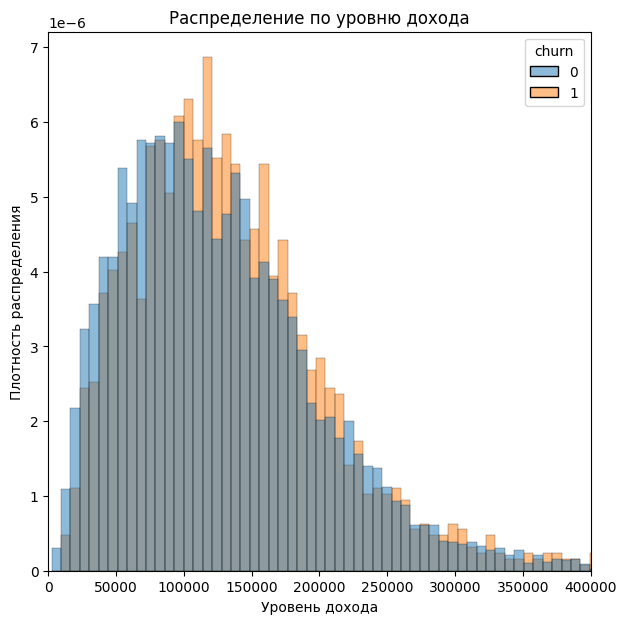

In [36]:
# Посмотрим на распределение по уровню дохода
fig, axs = plt.subplots(figsize=(7, 7))

sns.histplot(data=banks, x="est_salary", hue="churn", stat="density", common_norm=False, bins = 200)

axs.set_xlim([0, 400000])
plt.xlabel("Уровень дохода", size=10)
plt.ylabel("Плотность распределения", size=10)
plt.title("Распределение по уровню дохода")
plt.show()

Явной разницы не наблюдается, при этом пользователи с большим доходом более склонны к оттоку.

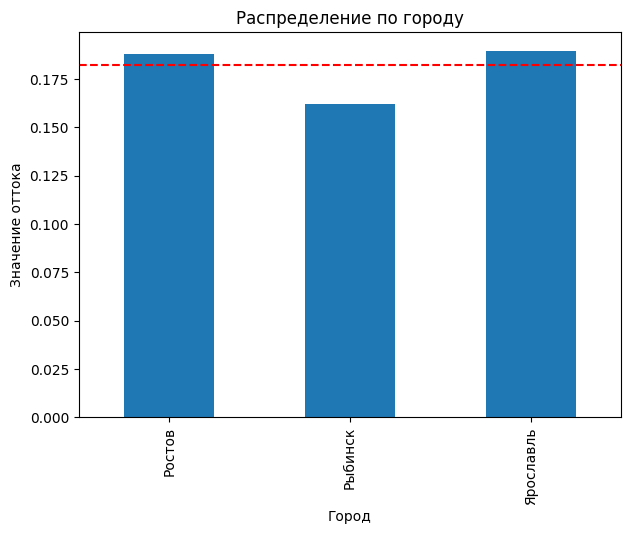

In [37]:
# Теперь посмотрим на категориальные признаки город и гендер.
# При это выведем на графике дополнительно среднее значение по оттоку
fig, ax = plt.subplots(figsize=(7, 5))
banks.groupby(['city'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = banks['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Город", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по городу")
plt.show()

В результате видим что значения привышают средний показатель в двух городах: Ростов и Ярославь.

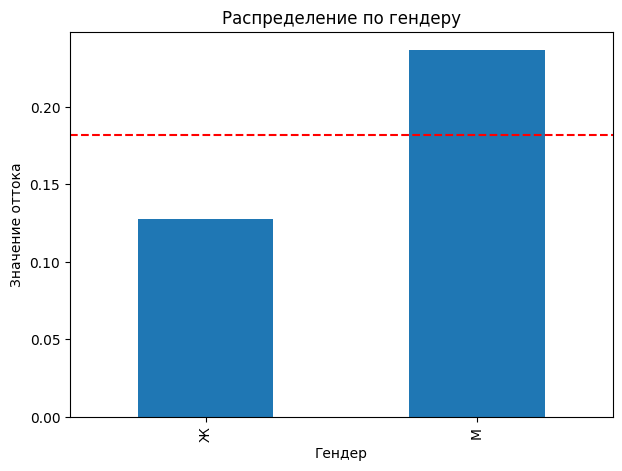

In [38]:
# Распределение по гендеру
fig, ax = plt.subplots(figsize=(7, 5))
banks.groupby(['gender'])['churn'].mean().plot(kind='bar', ax=ax)
average_churn = banks['churn'].mean()
ax.axhline(average_churn, color='r', linestyle='--')

plt.xlabel("Гендер", size=10)
plt.ylabel("Значение оттока", size=10)
plt.title("Распределение по гендеру")
plt.show()

Видим что среднее значение превышено у мужчин.

**Вывод:**
   
На основании проведенного анализа всех столбцов можно сказать, что склонны к оттоку:
- пользователи с более высокой оценкой скора;
- особенно выделяются возрастные группы в дипазонах от 25 до 30 и от 50 до 60 лет;
- с оценкой собственности от 3 до 9;
- с большим балансом;
- количеством продуктов более 2;
- более активные пользователи;
- без крединой карты;
- из городов Ростов и Ярославль;
- мужчины.

 ### Корреляционный анализ.

In [39]:
# Посмотрим на корреляционный анализ с использованием библиотеки phik
# Передадим в interval_cols непрерывные признаки
interval_cols = ['score', 'age', 'balance', 'est_salary']

In [40]:
phik_corr = banks.phik_matrix(interval_cols=interval_cols)

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable userid is large: 9927. Are you sure this is not an interval variable? Analysis for pairs of variables including userid can be slow.
  warnings.warn(


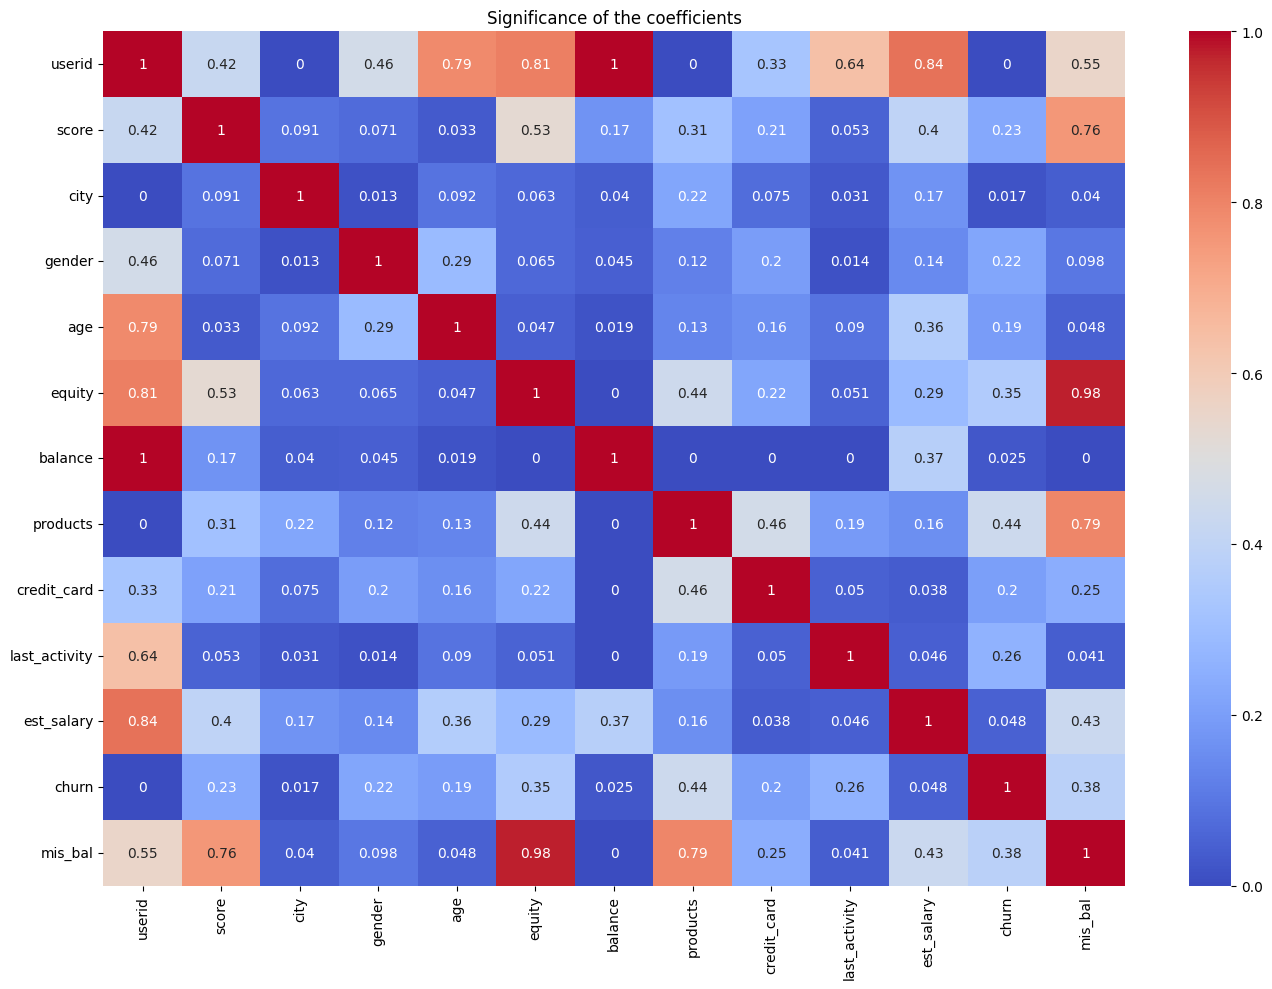

In [41]:
# Построим хитмам по собранной таблице
plt.figure(figsize=(14, 10))
sns.heatmap(phik_corr.fillna(0).values,
            cmap='coolwarm',
            xticklabels=phik_corr.columns,
            yticklabels=phik_corr.index,
            vmin=0, vmax=1, annot=True)
plt.title("Significance of the coefficients")
plt.tight_layout()
plt.show()

По хмапу можно сделать седующие выводы:
Наибольшая зависимость наблюдается между оттоком и количеством продуктов пользователя. Далее идут следующие столбцы: количество баллов собственности, активность пользователя, оценка скора.
    

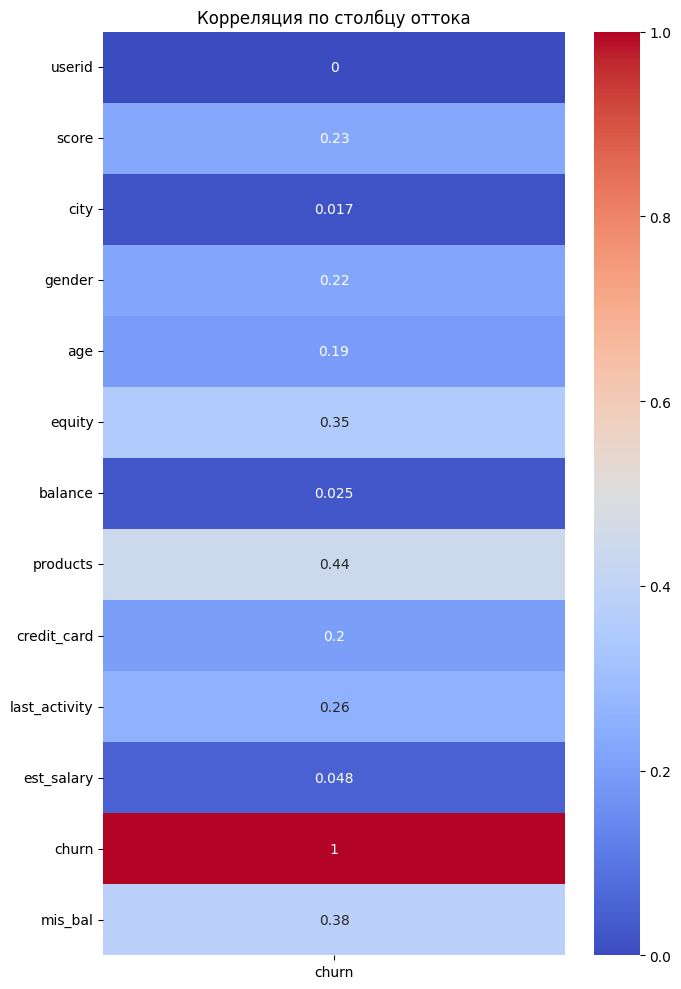

In [42]:
# Отдельно рассмотрим сам столбец оттока
churn_col = pd.DataFrame(phik_corr['churn'].fillna(0), columns=['churn'], index=phik_corr.index)

plt.figure(figsize=(7, 10))
sns.heatmap(churn_col,
            cmap='coolwarm',
            vmin=0, vmax=1, annot=True)
plt.title("Корреляция по столбцу оттока")
plt.tight_layout()
plt.show()

На основании полученных данных по столбцу оттока можно сказать, что высокой и очень высокой зависимости между показателем оттока и имеющимися данными не наблюдается. При этом имеется средняя положительная зависимость между оттоком и такими показателями:
- Количество продуктов(0,44);
- Количество баллов собственности(0,35);
- Активность пользователя(0,26).

Со всеми остальными показателями имеется слабая положительная зависимость. Значение в диапазоне от 0 до 0,24.

In [43]:
# Дополнительно посмотрим на меру центральной тенденции.
# Так как фукцию для медины мы уже писали просто переиспользуем ее.

# Затем соберем сводную таблицу
banks.groupby('churn').agg({
    'est_salary': ['mean'],
    'age': ['mean'],
    'score': ['mean'],
    'balance': ['mean'],
    'credit_card': ['mean'],
    'last_activity': ['mean'],
    'products': median,
    'equity': median,
    'city': pd.Series.mode,
    'gender': pd.Series.mode
}).reset_index()

,churn,est_salary,age,score,balance,credit_card,last_activity,products,equity,city,gender
,,mean,mean,mean,mean,mean,mean,median,median,mode,mode
0,0,147783.200108,43.020846,845.428362,7.339826e+05,0.709169,0.483741,2.0,3.0,Ярославль,Ж
1,1,148243.010198,41.450247,863.401099,1.133993e+06,0.551099,0.702198,2.0,4.0,Ярославль,М


В результате более явно выделяются следующие параметры пользователей склонных к оттоку:
- Пользователи с большим средним балансом;
- Пользователи без крединой карты;
- Более активные;
- Со средним количеством продуктов 2;
- При этом с большим баллом собственности;
- Из Ярославля;
- Мужчины.

**Вывод:**
В результате проведенного анализа данных получили два вариант показателей. Первый проведен на основе анализа гистограмм, второй корреляционного анализа.
В обоих случаях имеется взаимосвязь оттока со следующими показателями:
- Оценка скора;
- Активность пользователя;
- Количество продуктов банка;
- Баллы собственности;
- Город;
- Гендер.

Наиболее склонны к оттоку пользователи:
- Из Ростова и Ярославля;
- Мужчины;
- Активные пользователи;
- В наличии более 2 продуктов банка;
- Без крединой карты;
- С большим количеством баллов собственности;
- С более высокой оценкой скора.

## Шаг 4. Проверить гипотезы

### Проверить гипотезу по различию дохода клиентов что ушли и теми что остались

In [44]:
# Первым делом разделим датасет на две группы тех что ушли и тех что остались
banks_stayed = banks.loc[banks["churn"] == 0]
banks_stayed

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,mis_bal
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,1
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0,1
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0,0


In [45]:
# Вторая группа что ушли
banks_gone = banks.loc[banks["churn"] == 1]
banks_gone

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,mis_bal
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0
12,132970,845.0,Ярославль,Ж,31.0,3,591928.52,2,1,1,112697.16,1,0
40,129705,811.0,Рыбинск,М,34.0,2,129799.35,1,0,0,96242.71,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,154871,892.0,Рыбинск,М,39.0,5,636287.72,2,0,1,227288.27,1,0
9986,152986,822.0,Ярославль,М,58.0,5,1434857.91,2,0,1,83442.41,1,0
9987,151279,783.0,Рыбинск,Ж,61.0,3,387916.16,2,1,0,63160.96,1,0
9992,167165,813.0,Рыбинск,М,48.0,2,179765.62,2,1,0,133972.11,1,0


Прежде чем перейти к проверке гипотез нужно определится с методом. Поэтому рассмотрим критерии когда мы не можем использовать t-test.

1) t-тест предполагает, что дисперсии двух групп равны. Если это условие нарушено, то t-тест может дать неверные результаты.

2) t-тест требует, чтобы оба набора данных были достаточно велики (обычно n > 30). Если размер выборки мал, результаты могут быть недостоверными.

3) t-тест предполагает, что данные в каждой группе следуют нормальному распределению. Если данные не нормально распределены, результаты t-теста могут быть недостоверными.

Мы видим что наши данные в двух группах разчичаются по количеству строк. В певой таблице их более 8 тыс., во второй около 2 тыс. При этом данных у нас более 30, то есть оба набора достаточно велики. Так же стоит отметить что чем больше набор данных тем ближе он к нормальному распределению. А вот по первому пункуту мы не знаем равны ли дисперсии выборок, поэтому при использовании  t-теста зададим параметр equal_var=False. Таким образом ограничений по использованию t-теста нет.

Для проверки гипотезы воспользуемся методом из библиотеки scipy. Мы возьмем именно метод ttest_ind, так как он предназначен для проверки гипотезы о равенстве средних двух генеральных совокупностей

scipy.stats.ttest_ind(array1, array2, equal_var, alternative)

При этом у нас будет две гипотезы:

- Нулевая гипотеза: средние пользовательские доходы клиентов что ушли и теми что остались одинаковые.
- Альтернативная гипотеза: средние пользовательские доходы клиентов что ушли и теми что остались разные.

Альфа зададим равным 0.05

alpha = 0.05

In [46]:
# Задаём уровень значимости
alpha = 0.05

# Проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу
# Добавим значение equal_var=False
results = st.ttest_ind(banks_stayed['est_salary'],
                       banks_gone['est_salary'],
                       equal_var=False,
                       alternative='two-sided')

print(f'p-value: {results.pvalue}')

# Проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние пользовательские доходы клиентов что ушли и теми что остались разные')
else:
    print(
        'Нет оснований отвергнуть нулевую гипотезу: средние пользовательские доходы клиентов что ушли и что остались одинаковые'
    )

p-value: 0.8887054822123845
Нет оснований отвергнуть нулевую гипотезу: средние пользовательские доходы клиентов что ушли и что остались одинаковые


В результе получаем что у нас нет оснований отвергнуть нулевую гипотезу. Велика вероятность что средние пользовательские доходы клиентов что ушли и теми что остались одинаковые.

### Проверить гипотезу по различию баллов скорринга клиентов что ушли и теми что остались

Так как при анализе данных таблицы мы выявили что есть различия в баллах. И этот показатель влияет на отток. Именно этот столбец и проверим во второй гипотезе.

Второй гипотезой возьмемся проверить различия в баллах скорринга у пользователей что ушли и теми что остались.

Так как при проверке перво гипотезы мы уже разделили данные на две группы по оттоку, второй раз делить их не потребуется. Мы воспользуемся теми же таблицами что получили ранее:
- Пользователи что остались - banks_stayed;
- Пользователи что ушли - banks_gone.


Для проверки гипотезы так же воспользуемся методом ttest_ind.

scipy.stats.ttest_ind(array1, array2, equal_var, alternative)

При этом у нас будет две гипотезы:

Нулевая гипотеза: средние баллов скорринга клиентов что ушли и теми что остались одинаковые.
Альтернативная гипотеза: средние баллов скорринга клиентов что ушли и теми что остались разные.
Альфа зададим равным 0.05

alpha = 0.05

In [47]:
# Задаём уровень значимости
alpha = 0.05

# Проводим ttest для двух выборок, в качестве альтернативной используем двустороннюю гипотезу
# Добавим значение equal_var=False
results = st.ttest_ind(banks_stayed['score'],
                       banks_gone['score'],
                       equal_var=False,
                       alternative='two-sided')

print(f'p-value: {results.pvalue}')

# Проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние пользовательские доходы клиентов что ушли и теми что остались разные')
else:
    print(
        'Нет оснований отвергнуть нулевую гипотезу: средние пользовательские доходы клиентов что ушли и что остались одинаковые'
    )

p-value: 1.2043086927657869e-37
Отвергаем нулевую гипотезу: средние пользовательские доходы клиентов что ушли и теми что остались разные


В результате имеем подтверждение что нулевая гипотеза о равенстве средних баллов скоринга отвергнута. Велика вероятность, что баллы скоринга для групп что ушли и остались разные.

**Вывод:**

В результате проверки гипотезы по различию дохода клиентов что ушли и теми что остались получили.
У нас нет оснований отвергнуть нулевую гипотезу. Велика вероятность что средние пользовательские доходы клиентов что ушли и теми что остались одинаковые.

По различию баллов скорринга клиентов что ушли и теми что остались.
Имеем подтверждение что нулевая гипотеза о равенстве средних баллов скоринга отвергнута. Велика вероятность, что баллы скоринга для групп что ушли и остались разные.

## Шаг 5. Промежуточные итоги

1) На первом этапе знакомства с данными выяснили что в таблице всего 10000 строк. При это имеются пропуски в двух столбцах: возраст и баланс. Пропусков в столбце возраст меньше процента, поэтому их оставим без изменения. Влияния на результаты исследования они не окажут. А вот в столбце баланс целых 23% пропусков, природу которых мы выясним на следущем этапе.

Что касается дубликатов. Явных дубликатов не обнаружено. При этом есть дубли в юзер айди. После проверки мы пришли к выводу что это разные пользователи, есть совпадение только в самом айди пользователя.

2) На тором этапе проверил, что между пропусками в столбце баланса и другими столбцами имеется взаимосвязь. То есть пропуски имеются у пользователей кто не очень активно пользуется продуктами банка и о которых у банка недостаточно сведений. При этом больше пропусков у мужчин со средним оценочным доходом 226 тыс. Поэтому данные пропуски убирать не будем.

Так же провели преобразование названия столбцов к нижнему регистру.

3) В результате проведенного анализа данных получили два варианта показателей. Первый проведен на основе анализа гистограмм, второй корреляционного анализа. В обоих случаях имеется взаимосвязь оттока со следующими показателями:

- Оценка скора;
- Активность пользователя;
- Количество продуктов банка;
- Баллы собственности;
- Город;
- Гендер.

Наиболее склонны к оттоку пользователи:

- Из Ростова и Ярославля;
- Мужчины;
- Активные пользователи;
- В наличии более 2 продуктов банка;
- Без крединой карты;
- С большим количеством баллов собственности;
- С более высокой оценкой скора.

4) На четвертом этапе проверили две гипотезы.

В результате проверки гипотезы по различию дохода клиентов что ушли и теми что остались получили. У нас нет оснований отвергнуть нулевую гипотезу. Велика вероятность что средние пользовательские доходы клиентов что ушли и теми что остались одинаковые.

По различию баллов скорринга клиентов что ушли и теми что остались. Имеем подтверждение что нулевая гипотеза о равенстве средних баллов скоринга отвергнута. Велика вероятность, что баллы скоринга для групп что ушли и остались разные.

Таким образом сегментацию пользователей будем проводит на основе уже опреденных критериев:

- Активность(last_activity);
- Количество продуктов(products);
- Баллы собственности(equity).


## Шаг 6. Сегментация клиентов

### Проведение сегментации клиентов

Сегментацию пользователей будем проводить на основе машинного обучения. С использованием KMeans.
Данный способ был выбран с целью более точного деления пользователей на группы. К тому же метод KMeans легко справится с достаточно большим объемом данных. И подойдет для кластеризации оттока нашего банка.

In [48]:
# Перед тем как приступить к кластеризации сформируем новую таблицу только с выбранными столбцами.
banks_for_cluster = banks[['last_activity', 'products', 'equity']]

In [49]:
# Так как нам нужны кластеры с оттоком выше среднего посчитаем среднее значение оттока по таблице.
banks['churn'].mean()

0.182

In [54]:
# Стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(banks_for_cluster)
# Построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

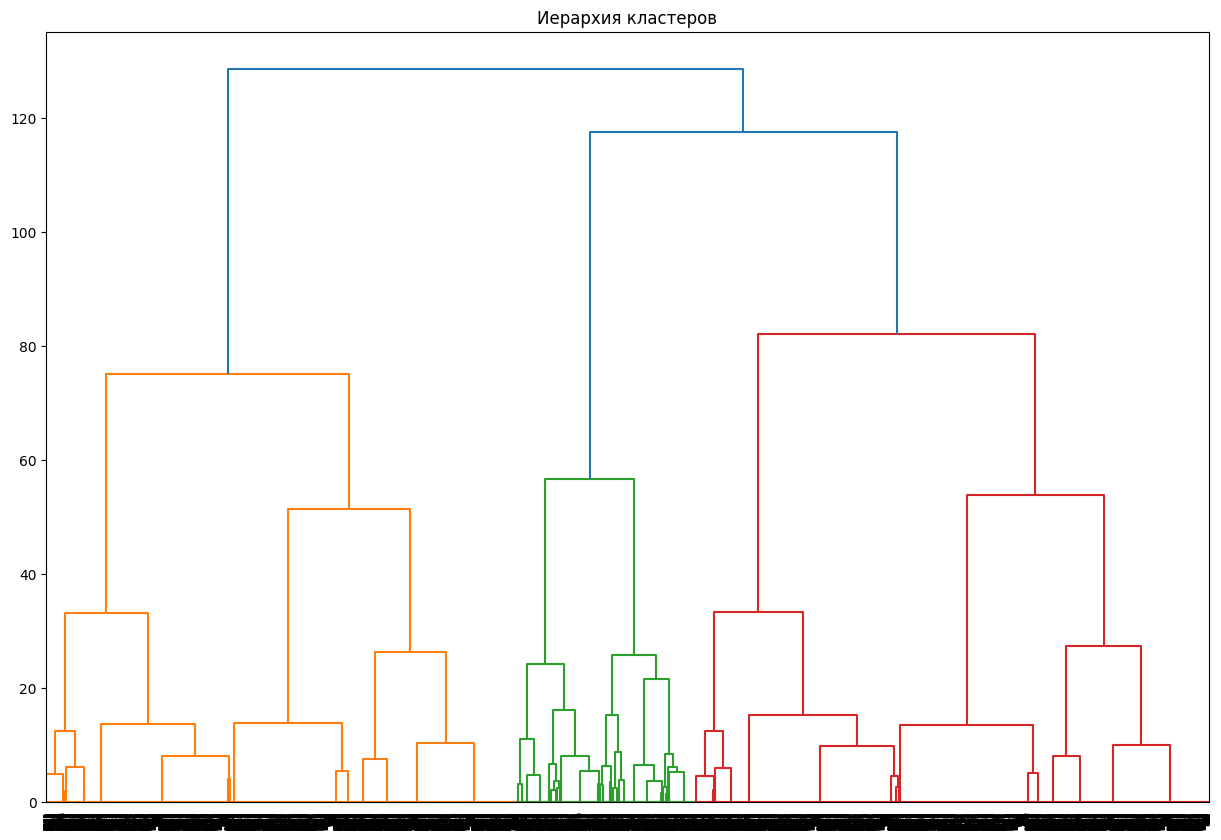

In [56]:
# Отобразим дендрограмму
import sys
sys.setrecursionlimit(3000)
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеров')
plt.show()

In [57]:
# Проведем кластеризацию с импользованием KMeans и разбивкой на 4 кластеров
km = KMeans(n_clusters=3, random_state=42)

labels = km.fit_predict(X_sc)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
# Сохраняем метки кластера в датасете
banks['cluster_km'] = labels

# Выведем статистику по средним значениям и медианам
banks.groupby('cluster_km').agg({
    'products': median,
    'equity': median,
    'last_activity': ['mean']
}).reset_index()

,cluster_km,products,equity,last_activity
,,median,median,mean
0,0,2.0,4.0,1.000000
1,1,2.0,4.0,0.000000
2,2,1.0,0.0,0.590203


### Проведение приоретизации полученных сегментов

In [59]:
# Вычислим количество пользователей в каждом кластере
user_counts = banks['cluster_km'].value_counts()

# Вычислим количество пользователей, которые ушли в каждом кластере
churn_counts = banks[banks['churn'] == 1]['cluster_km'].value_counts()

# Вычислим долю оттока для каждого кластера
churn_rates = round((churn_counts / user_counts) * 100,2)

# Создаем сводную таблицу
result_table = pd.DataFrame({
    'User Count': user_counts,
    'Churn Count': churn_counts,
    'Churn Rate': churn_rates
})
result_table.sort_values('Churn Rate', ascending=False, inplace=True)
result_table

,User Count,Churn Count,Churn Rate
0,3259,1150,35.29
1,3393,484,14.26
2,3348,186,5.56


Так как в результате кластеризации мы получаем только один подходящий сегмент с долей оттока выше среднего по банку, а нужно минимум три. При этом варианты пересчета кластеров при обучении модели KMeans не помогают улучшить результат. Попробуем другой подход определения количества кластеров.

Воспользуемся методом Давида-Болдуина и критерием Калински-Харабаса для определения оптимального количества кластеров в данных, так как они обеспечивают хорошую оценку качества кластеризации.

Метод Давида-Болдуина (DBI) измеряет степень сходства между кластерами в решении кластеризации. Он рассчитывается как среднее сходство каждого кластера с его наиболее похожим кластером. Индекс Давида-Болдуина варьируется от 0 до бесконечности, где низкое значение указывает на лучшее решение кластеризации.

Критерии Калински-Харабаса определяется как отношение между межкластерной дисперсией и общей дисперсией для заданного числа кластеров k. Чем больше это отношение, тем более схожи кластеры.

Возьмем оба этих метода для получения более точного представления о структуре данных. Они позволят выбрать оптимальное количество кластеров, основываясь на их эффективности в разделении данных.

In [60]:
# Подготовим данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(banks_for_cluster)

In [61]:
# Оценим индексы Давида-Болдуина и Калински-Харабаса для различных значений k
best_k = 0
lowest_db = float("Inf")
lowest_ch = float("-Inf")

# Выберем диапазон для k
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit_predict(scaled_data)

    db = davies_bouldin_score(scaled_data, model)
    ch = calinski_harabasz_score(scaled_data, model)

    if db < lowest_db and ch > lowest_ch:
        best_k = k
        lowest_db = db
        lowest_ch = ch

print("Подходящее количество кластеров: ", best_k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Подходящее количество кластеров:  9


In [62]:
# Проведем кластеризацию с импользованием KMeans и разбивкой на 5 кластеров
km = KMeans(n_clusters=9, random_state=42)

labels = km.fit_predict(X_sc)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [63]:
# Сохраняем метки кластера в датасете
banks['cluster_km'] = labels

# Выведем статистику по средним значениям и медианам
banks.groupby('cluster_km').agg({
    'products': median,
    'equity': median,
    'last_activity': ['mean']
}).reset_index()

,cluster_km,products,equity,last_activity
,,median,median,mean
0,0,2.0,2.0,0.0
1,1,4.0,4.0,1.0
2,2,2.0,2.0,1.0
3,3,1.0,4.0,0.0
4,4,2.0,5.0,0.0
5,5,2.0,4.0,1.0
6,6,1.0,0.0,0.0
7,7,1.0,0.0,1.0
8,8,3.0,4.0,0.0


In [64]:
# Вычислим количество пользователей в каждом кластере
user_counts = banks['cluster_km'].value_counts()

# Вычислим количество пользователей, которые ушли в каждом кластере
churn_counts = banks[banks['churn'] == 1]['cluster_km'].value_counts()

# Вычислим долю оттока для каждого кластера
churn_rates = round((churn_counts / user_counts) * 100,2)

# Создаем сводную таблицу
result_table = pd.DataFrame({
    'User Count': user_counts,
    'Churn Count': churn_counts,
    'Churn Rate': churn_rates
})
result_table.sort_values('Churn Rate', ascending=False, inplace=True)
result_table

,User Count,Churn Count,Churn Rate
1,731,371,50.75
5,1758,596,33.90
8,627,200,31.90
2,1434,272,18.97
4,1152,133,11.55
0,1409,128,9.08
3,467,38,8.14
6,1110,43,3.87
7,1312,39,2.97


В данном случае получаем что у нас имеется четыре кластера с показателем оттока более 18,2%

**Вывод:**

В результате проведенной сегментации мы получили 9 сегментов пользователей с количеством в каждом от 569 до 1758. При этом четыре сегмента удовлетворяют условию что процент оттока превышает средний по таблице(18,2%). Рассмотрим подробнее сегменты:
- 0 сегмент - не активные пользователи с медианным значением количества продуктов 2 и оценкой собственности 2. Отток 9,08%.
- 1 сегмент - активные пользователи с медианным значением количества продуктов 4 и оценкой собственности 4. Отток 50,75%.
- 2 сегмент - активные пользователи с медианным значением количества продуктов 2 и оценкой собственности 2. Отток 18,97%.
- 3 сегмент - не активные пользователи с медианным значением количества продуктов 1 и оценкой собственности 4. Отток 8,44%.
- 4 сегмент - не активные пользователи с медианным значением количества продуктов 2 и оценкой собственности 5. Отток 11,54%.
- 5 сегмент - активные пользователи с медианным значением количества продуктов 2 и оценкой собственности 4. Отток 33,90%.
- 6 сегмент - не активные пользователи с медианным значением количества продуктов 1 и оценкой собственности 0. Отток 3,28%.
- 7 сегмент - активные пользователи с медианным значением количества продуктов 1 и оценкой собственности 0. Отток 2,97%.
- 8 сегмент - не активные пользователи с медианным значением количества продуктов 3 и оценкой собственности 4. Отток 31,90%.


## Шаг 7. Написать общий вывод

На основании приоретизации, что сделали на прошлом этапе видим, что в первую очередь нужно работать с четырмя сегментами в порядке их важности:
 - 1 сегмент - активные пользователи с медианным значнием количества продуктов 4 и высокой оценкой собственности;
 - 5 сегмент - активные пользователи с медианным значнием количества продуктов 2 и высокой оценкой собственности;
 - 8 сегмент - не активные пользователи с медианным значнием количества продуктов 3 и высокой оценкой собственности;
 - 2 сегмент - активные пользователи с медианным значнием количества продуктов 2 и средней оценкой собственности.

Рекомендации:

- 1 сегмент - Так как в этом сегменте находятся пользователи у которых имеются уже продукты банка в количестве около 4 и есть высокая оценка собственности, можно заключить что это активные и постоянные пользователи банка. Для их удержания стоит подчеркнуть важность таких пользователей для банка, а именно рассмотреть варианты индивидуальных предложений. Например, если пользователь часто использует кредитную карту, рассмотреть дополнительные льготы по карте, чтобы у пользователя сохранялось желание использовать продукт по максимуму. В том числе возможность решать банковские вопросы с личным менеджером. Кроме того банк может предложить своим постоянным пользователям одними из первых знакомится с новыми продуктами и механизмами их использования.


- 5 сегмент - В этом сегменте находятся активные пользователи с высокой оценкой собственности и поличеством продуктов 2. То есть наша цель предложить пользователю дополниетльные продукты банка на более выгодных условиях. Например льготный кредит на приобретение автомобиля, либо более выгодные проуенты по депозиту.


- 8 сегмент - Так как в сегмента так же находятся пользователи с высокой оценкой собственности и количеством продуктов 3. Стоит так же рассмотреть возможность индивидуальных предложений по продуктам банка. А так же помощь индивидульного менеджера по банковским услугам. Кроме этого банк может предложить повышенный кешбэк по имеющимся картам банка.


- 2 сегмент - Так как пользователи в данном сегменте имеют всего 2 продукта банка стоит провести мероприятия по ознакомлению с ассортиментом банка, чтобы кажды мог подобрать себе что-то еще. Кроме этого стоит посмотреть каких продуктов у пользователей нет и предложить дополнительные льготные условия. Например если пользователь является владельцем заплатной карты банка, можно предложить разместить депозит с более выгодным процентом.
